<a href="https://colab.research.google.com/github/sairaja-2654/IPLscorepredictionusingML/blob/main/iplscoreprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import ipywidgets as widgets
from IPython.display import display, clear_output

In [ ]:
# Load the dataset
ipl = pd.read_csv('ipl_data.csv')

In [ ]:
# Dropping certain features
df = ipl.drop(['date', 'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5','mid', 'striker', 'non-striker'], axis=1)
X = df.drop(['total'], axis=1)
y = df['total']

In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Create a LabelEncoder object for each categorical feature
venue_encoder = LabelEncoder()
batting_team_encoder = LabelEncoder()
bowling_team_encoder = LabelEncoder()
striker_encoder = LabelEncoder()
bowler_encoder = LabelEncoder()

In [ ]:
# Fit and transform the categorical features with label encoding
X['venue'] = venue_encoder.fit_transform(X['venue'])
X['bat_team'] = batting_team_encoder.fit_transform(X['bat_team'])
X['bowl_team'] = bowling_team_encoder.fit_transform(X['bowl_team'])
X['batsman'] = striker_encoder.fit_transform(X['batsman'])
X['bowler'] = bowler_encoder.fit_transform(X['bowler'])

In [ ]:
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define the neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)), # Input layer
    keras.layers.Dense(512, activation='relu'), # Hidden layer with 512 units and ReLU activation
    keras.layers.Dense(216, activation='relu'), # Hidden layer with 216 units and ReLU activation
    keras.layers.Dense(1, activation='linear') # Output layer with linear activation for regression
])

In [ ]:
# Compile the model with Huber loss
huber_loss = tf.keras.losses.Huber(delta=1.0) # You can adjust the 'delta' parameter as needed
model.compile(optimizer='adam', loss=huber_loss) # Use Huber loss for regression


Epoch 1/50
832/832 [==============================] - 8s 8ms/step - loss: 32.5583 - val_loss: 22.5098
Epoch 2/50
832/832 [==============================] - 6s 7ms/step - loss: 22.3095 - val_loss: 21.9657
Epoch 3/50
832/832 [==============================] - 6s 7ms/step - loss: 22.1141 - val_loss: 22.0915
Epoch 4/50
832/832 [==============================] - 6s 7ms/step - loss: 22.0139 - val_loss: 21.7972
Epoch 5/50
832/832 [==============================] - 7s 8ms/step - loss: 22.0103 - val_loss: 21.6167
Epoch 6/50
832/832 [==============================] - 6s 7ms/step - loss: 21.9493 - val_loss: 21.6674
Epoch 7/50
832/832 [==============================] - 6s 7ms/step - loss: 21.8884 - val_loss: 21.6542
Epoch 8/50
832/832 [==============================] - 6s 7ms/step - loss: 21.8377 - val_loss: 21.4596
Epoch 9/50
832/832 [==============================] - 6s 7ms/step - loss: 21.7712 - val_loss: 21.3591
Epoch 10/50
832/832 [==============================] - 5s 6ms/step - loss: 21.6621

<Axes: >

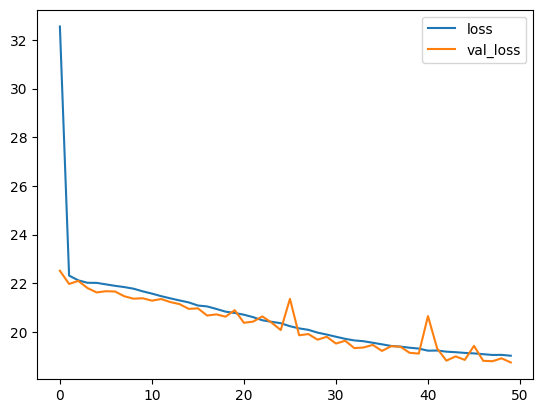

In [ ]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_data=(X_test_scaled, y_test))
model_losses = pd.DataFrame(model.history.history)
model_losses.plot()

In [ ]:
# Make predictions
predictions = model.predict(X_test_scaled)

713/713 [==============================] - 2s 2ms/step


In [ ]:
# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
print(mae)

19.225451265053643


In [ ]:
# Print mean absolute error
print("Mean Absolute Error:", mae)

Mean Absolute Error: 19.225451265053643


In [ ]:
# Hyperparameter tuning using GridSearchCV with Random Forest Regressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
best_rf_model = grid_search.best_estimator_

In [ ]:
# Make predictions with the best model
y_pred_rf = best_rf_model.predict(X_test_scaled)

In [ ]:
# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
accuracy_percentage_rf = 100 * (1 - mae_rf / np.mean(y_test))

In [ ]:
# Adjusted R-squared as accuracy

print("Random Forest Mean Absolute Error:", mae_rf)
print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest Accuracy:", accuracy_percentage_rf, "%")

Random Forest Mean Absolute Error: 2.137281057694656
Random Forest Mean Squared Error: 54.30004161076676
Random Forest Accuracy: 98.67307448071298 %


In [ ]:
# Create interactive widgets for user input
venue = widgets.Dropdown(options=df['venue'].unique().tolist(), description='Select Venue:')
batting_team = widgets.Dropdown(options=df['bat_team'].unique().tolist(), description='Select Batting Team:')
bowling_team = widgets.Dropdown(options=df['bowl_team'].unique().tolist(), description='Select Bowling Team:')
striker = widgets.Dropdown(options=df['batsman'].unique().tolist(), description='Select Striker:')
bowler = widgets.Dropdown(options=df['bowler'].unique().tolist(), description='Select Bowler:')
predict_button = widgets.Button(description="Predict Score")
output = widgets.Output()

In [ ]:
# Define function to predict score
def predict_score(b):
    with output:
        clear_output() # Clear the previous output

        # Decode the encoded values back to their original values
        decoded_venue = venue_encoder.transform([venue.value])
        decoded_batting_team = batting_team_encoder.transform([batting_team.value])
        decoded_bowling_team = bowling_team_encoder.transform([bowling_team.value])
        decoded_striker = striker_encoder.transform([striker.value])
        decoded_bowler = bowler_encoder.transform([bowler.value])

        input_data = np.array([decoded_venue, decoded_batting_team, decoded_bowling_team, decoded_striker, decoded_bowler])
        input_data = input_data.reshape(1, 5)
        input_data = scaler.transform(input_data)
        # Make prediction using the neural network model
        predicted_score_nn = model.predict(input_data)
        predicted_score_nn = int(predicted_score_nn[0, 0])
        print("Predicted Score (Neural Network):", predicted_score_nn)

        # Make prediction using the best Random Forest model
        predicted_score_rf = best_rf_model.predict(input_data)
        predicted_score_rf = int(predicted_score_rf[0])
        print("Predicted Score (Random Forest):", predicted_score_rf)

In [ ]:
# Assign function to predict button click event
predict_button.on_click(predict_score)

In [ ]:
# Display widgets and output
display(venue, batting_team, bowling_team, striker, bowler, predict_button, output)

Dropdown(description='Select Venue:', options=('M Chinnaswamy Stadium', 'Punjab Cricket Association Stadium, M…

Dropdown(description='Select Batting Team:', options=('Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasth…

Dropdown(description='Select Bowling Team:', options=('Royal Challengers Bangalore', 'Kings XI Punjab', 'Delhi…

Dropdown(description='Select Striker:', options=('SC Ganguly', 'BB McCullum', 'RT Ponting', 'DJ Hussey', 'Moha…

Dropdown(description='Select Bowler:', options=('P Kumar', 'Z Khan', 'AA Noffke', 'JH Kallis', 'SB Joshi', 'CL…

Button(description='Predict Score', style=ButtonStyle())

Output()